In [1]:
#import libraries
!pip install datasets
from datasets import Dataset,DatasetDict,Features,Value,ClassLabel
from transformers import AutoTokenizer
from transformers import pipeline
from torch.nn.functional import cross_entropy
import plotly.express as px
import pandas as pd
import numpy as np
import panel as pn
import warnings; warnings.filterwarnings('ignore')

def show_panel(df):
    return pn.widgets.Tabulator(df.head(20),
                    show_index=False,
                    pagination='local',
                         page_size=10)


pn.extension('tabulator')
pn.widgets.Tabulator.theme = 'bootstrap'

# Reading files
validation = pd.read_csv('/content/drive/MyDrive/validation.csv')
train = pd.read_csv('/content/drive/MyDrive/training.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')

print('Dataset information:')
print(f'Training data: {train.shape}')
print(f'Validation data: {validation.shape}')
print(f'Test data: {test.shape}')
show_panel(train)


Dataset information:
Training data: (16000, 2)
Validation data: (2000, 2)
Test data: (2000, 2)


Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

In [2]:
# the class label data
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
ft = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})

# Combine Multiple Datasets
emotions = DatasetDict({
    "train": Dataset.from_pandas(train,features=ft),
    "test": Dataset.from_pandas(test,features=ft),
    "validation": Dataset.from_pandas(validation,features=ft)
    })

# Convert a single DataFrame to a Dataset
# emotions = Dataset.from_pandas(train,features=ft)

emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
# Training Data
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [4]:
# Get First 5 Entries in Dictionary Format (Group them)
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [5]:
# Convert Dataset to DataFrame
emotions.set_format(type="pandas")
df = emotions["train"][:]
pn.extension('tabulator')
show_panel(df)



Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

In [6]:
# Add label data to dataframe
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
pn.extension('tabulator')
show_panel(df)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

**1. CLASS DISTRIBUTION**

The dataset has 6 classes joy, sadness, anger, fear, love and surprise

In [7]:
px.bar(df['label_name'].value_counts(ascending=True),template='plotly_white')

**2. TOKENISATION**

Like other models, DistilBERT can't process raw Python strings directly. Instead, we must first convert these strings into tokens and then encode them into numerical vectors. There are two main tokenization methods: character tokenization and word tokenization.

**Subword Tokenization**: This method aims to blend the advantages of both character and word tokenization. What sets subword tokenization apart is that it is derived from a pretraining corpus using a combination of statistical rules and algorithms. Several subword tokenization algorithms are frequently used in NLP. The `AutoTokenizer` class enables us to easily load the tokenizer associated with a pretrained model.

In [8]:
text = 'Tokenisation of text is a core task of NLP.'

# Load parameters of the tokeniser
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Show tokeniser information
tokenizer


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [9]:
print('')
print(f'Vocab size: {tokenizer.vocab_size}')
print(f'Max length: {tokenizer.model_max_length}')
print(f'Tokeniser model input names: {tokenizer.model_input_names}')


Vocab size: 30522
Max length: 512
Tokeniser model input names: ['input_ids', 'attention_mask']


In [10]:
print('Encoded text')
encoded_text = tokenizer(text)
print(encoded_text,'\n')

print('Tokens')
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens,'\n')

print('Convert tokens to string')
print(tokenizer.convert_tokens_to_string(tokens),'\n')

Encoded text
{'input_ids': [101, 19204, 6648, 1997, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 

Tokens
['[CLS]', 'token', '##isation', 'of', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]'] 

Convert tokens to string
[CLS] tokenisation of text is a core task of nlp. [SEP] 



In [12]:
emotions.reset_format()

**Tokenising the entire dataset**

When tokenizing an entire dataset, the tokenizer will pad sentences that are too short to a specified length if padding is enabled. The maximum length of the tokenized data will be determined by the length of the longest tweet. An attention mask is used to indicate which parts of the sentence the model should ignore.

In [13]:
# Tokenisation function
def tokenise(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Show the tokenised ids
ex_tokenised = tokenise(emotions["train"][:2])

In [14]:
# Show attention mask
ex_tokenised['attention_mask']

[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

In [15]:
# apply to the entire dataset (train,test and validation dataset)
emotions_encoded = emotions.map(tokenise, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


**TRAINING THE MODEL**

There are two approaches to train the model:

a) *Feature Extraction* : In this approach, we use the hidden states as features and only train the classifier on these features, leaving the pretrained model unchanged.

b) *Fine-Tuning* : Here, we train the entire model end-to-end, which updates both the classifier and the parameters of the pretrained model.



**Using Pretrained Models:**

We will use another class, `AutoModel`, which is similar to `AutoTokenizer`. The `AutoModel` class includes a `from_pretrained` method for loading the weights of a pretrained model. This class converts token encodings into embeddings and processes them through the encoder stack to produce hidden states.

In [16]:
import warnings; warnings.filterwarnings('ignore')
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [17]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [18]:
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [19]:
print(outputs.last_hidden_state.size())
print(outputs.last_hidden_state[:,0].size())

torch.Size([1, 6, 768])
torch.Size([1, 768])


In [20]:
def extract_hidden_states(batch):

    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [21]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [22]:
# Extract last hidden states (faster w/ GPU)
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

**Feature Matrix Creation**

We now have hidden states for each tweet. The next step is to train the classifier. To do this, we need to create a feature matrix from these hidden states to use as input for the machine learning model.

In [37]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(f'Training Dataset: {X_train.shape}')
print(f'Validation Dataset {X_valid.shape}')

Training Dataset: (16000, 768)
Validation Dataset (2000, 768)


In [40]:
# Let's check our dataset
X_train

array([[-0.1167513 ,  0.09857138, -0.12962897, ...,  0.0587108 ,
         0.35432693,  0.4042067 ],
       [-0.03236292, -0.03231524, -0.19572599, ..., -0.17465737,
         0.35463768,  0.30276582],
       [ 0.03974647,  0.2022336 ,  0.14227113, ..., -0.11406833,
         0.33937776,  0.395831  ],
       ...,
       [-0.00339847, -0.09585506,  0.05843544, ..., -0.04272703,
         0.2495916 ,  0.30761623],
       [ 0.06660261,  0.17334324,  0.12896673, ...,  0.06118569,
         0.29038215,  0.46844164],
       [ 0.01668789,  0.10127088, -0.00731721, ..., -0.06493651,
         0.34540522,  0.21993564]], dtype=float32)

**Training Data Visualisation**

We can visualize the distribution of each class that the model needs to distinguish by projecting the data onto a lower-dimensional space. If we observe significant overlap among categories in this lower-dimensional representation, it suggests that they might still be distinguishable in higher dimensions. To aid this process, we'll use a manifold learning technique called t-SNE, which is an unsupervised model for dimensionality reduction.

In [41]:
import warnings; warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# Scale the data
X_scaled = MinMaxScaler().fit_transform(X_train)

# lower dimension transformation
model = TSNE(n_components=2).fit(X_scaled)

# Create a df of 2D embeddings
df_embedding = pd.DataFrame(model.embedding_, columns=["X", "Y"])
df_embedding["label"] = y_train

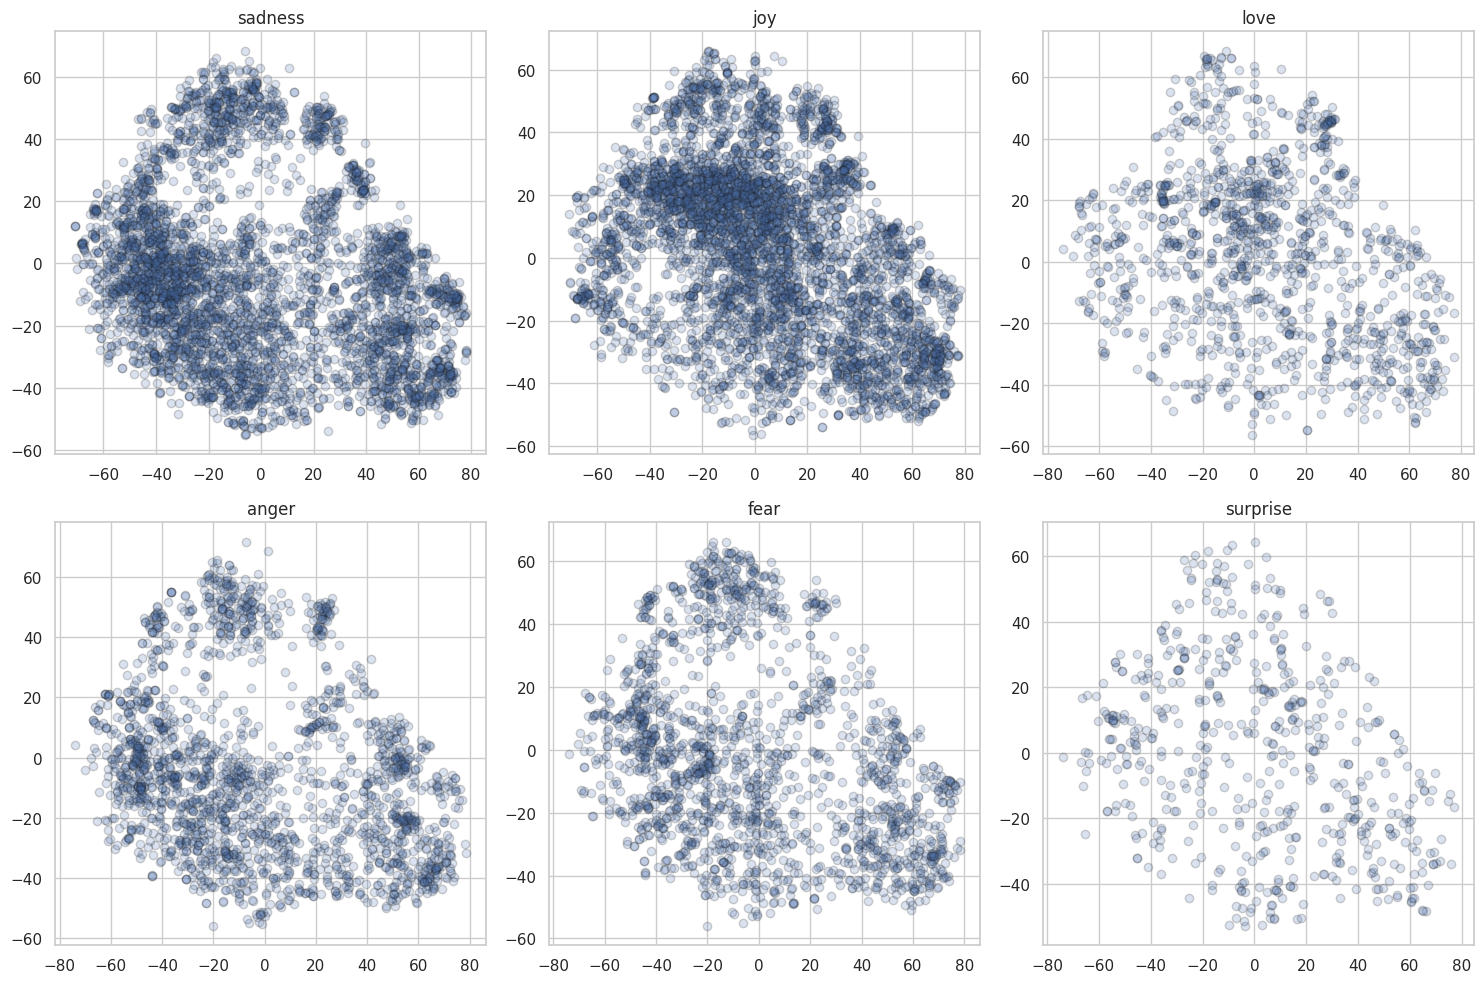

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.flatten()
labels = emotions["train"].features["label"].names

for i, label in enumerate(labels):

    dict_embedding_sub = dict(tuple(df_embedding.groupby('label')))
    df_embedding_sub = dict_embedding_sub[i]

    axes[i].scatter(df_embedding_sub["X"],
                    df_embedding_sub["Y"],
                    lw=1,ec='k',alpha=0.2)

    axes[i].set_title(f'{label}')
plt.tight_layout()
plt.show()

**Training a Baseline Model**

Let's use these hidden states to train a logistic regression model

In [46]:
from sklearn.linear_model import LogisticRegression as LR

# We increase `max_iter` to guarantee convergence
lr_clf = LR(max_iter = 2000)
lr_clf.fit(X_train, y_train)
y_preds = lr_clf.predict(X_valid)
print(f'accuracy: {lr_clf.score(X_valid, y_valid)}')

accuracy: 0.6335


**Confusion Matrix**

Let's check the confusion matrix of the logistic regression model.

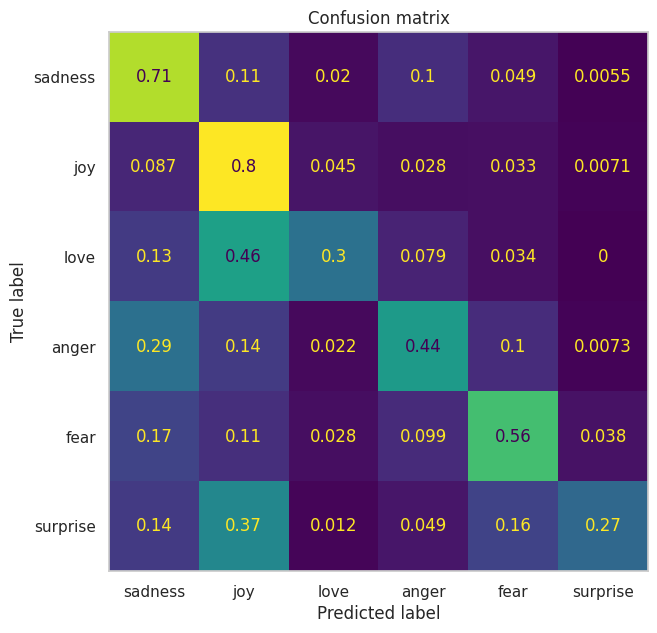

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_model, y_true, labels):
    cm = confusion_matrix(y_true,y_model,normalize='true')
    fig, ax = plt.subplots(figsize=(7,7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, colorbar=False)
    plt.title("Confusion matrix")
#     plt.axis('off')
    plt.grid(False)
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

**FINE-TUNING**

Loading a Pretrained Model

In [53]:
from transformers import AutoModelForSequenceClassification

num_labels = 6

model_ckpt = "distilbert-base-uncased"
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt,
                          num_labels=num_labels)
         .to(device))

**Defining the Performance Metrics**

In [54]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

**Training parameters**

In [55]:
from transformers import Trainer, TrainingArguments

bs = 64 # batch size
logging_steps = len(emotions_encoded["train"]) // bs
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,             # number of training epochs
                                  learning_rate=2e-5,             # model learning rate
                                  per_device_train_batch_size=bs, # batch size
                                  per_device_eval_batch_size=bs,  # batch size
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  report_to="none",
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

**Train the model**

In [56]:
import os
from transformers import Trainer
os.environ['WANDB_DISABLED'] = 'true'

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.810600,0.296523,0.908500,0.908354
2,0.219500,0.185113,0.926000,0.926192
3,0.149800,0.171432,0.933000,0.933150


TrainOutput(global_step=750, training_loss=0.3933197530110677, metrics={'train_runtime': 359.0093, 'train_samples_per_second': 133.701, 'train_steps_per_second': 2.089, 'total_flos': 1080514292544000.0, 'train_loss': 0.3933197530110677, 'epoch': 3.0})

In [57]:
# Predict on Validation Dataset
pred_output = trainer.predict(emotions_encoded["validation"])
pred_output

PredictionOutput(predictions=array([[ 4.7888207 , -0.9556427 , -1.4642508 , -1.3141698 , -1.400272  ,
        -2.209647  ],
       [ 4.7724557 , -1.1261905 , -1.9545105 , -1.0162617 , -1.055461  ,
        -2.3511875 ],
       [-1.2787137 ,  2.0802426 ,  3.2678187 , -1.3263861 , -2.6365073 ,
        -1.7551013 ],
       ...,
       [-0.95165527,  5.0243487 , -0.2511506 , -1.4565505 , -2.326896  ,
        -1.6366997 ],
       [-1.6454929 ,  3.4805458 ,  2.2897952 , -1.4436532 , -2.674231  ,
        -1.6845844 ],
       [-1.4787695 ,  4.8552566 , -0.38490617, -1.8567555 , -2.1854572 ,
        -0.64066184]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.17143194377422333, 'test_accuracy': 0.933, 'test_f1': 0.933149831834274, 'test_runtime': 3.911, 'test_samples_per_second': 511.373, 'test_steps_per_second': 8.182})

In [58]:
print(f'Output Predition: {pred_output.predictions.shape}')
print(pred_output.predictions)

Output Predition: (2000, 6)
[[ 4.7888207  -0.9556427  -1.4642508  -1.3141698  -1.400272   -2.209647  ]
 [ 4.7724557  -1.1261905  -1.9545105  -1.0162617  -1.055461   -2.3511875 ]
 [-1.2787137   2.0802426   3.2678187  -1.3263861  -2.6365073  -1.7551013 ]
 ...
 [-0.95165527  5.0243487  -0.2511506  -1.4565505  -2.326896   -1.6366997 ]
 [-1.6454929   3.4805458   2.2897952  -1.4436532  -2.674231   -1.6845844 ]
 [-1.4787695   4.8552566  -0.38490617 -1.8567555  -2.1854572  -0.64066184]]


In [59]:
# Decode the predictions greedily using argmax (highest value of all classes)
y_preds = np.argmax(pred_output.predictions,axis=1)
print(f'Output Prediction:{y_preds.shape}')
print(f'Predictions: {y_preds}')

Output Prediction:(2000,)
Predictions: [0 0 2 ... 1 1 1]


In [60]:
# Show metrics of last iteration
pred_output.metrics

{'test_loss': 0.17143194377422333,
 'test_accuracy': 0.933,
 'test_f1': 0.933149831834274,
 'test_runtime': 3.911,
 'test_samples_per_second': 511.373,
 'test_steps_per_second': 8.182}

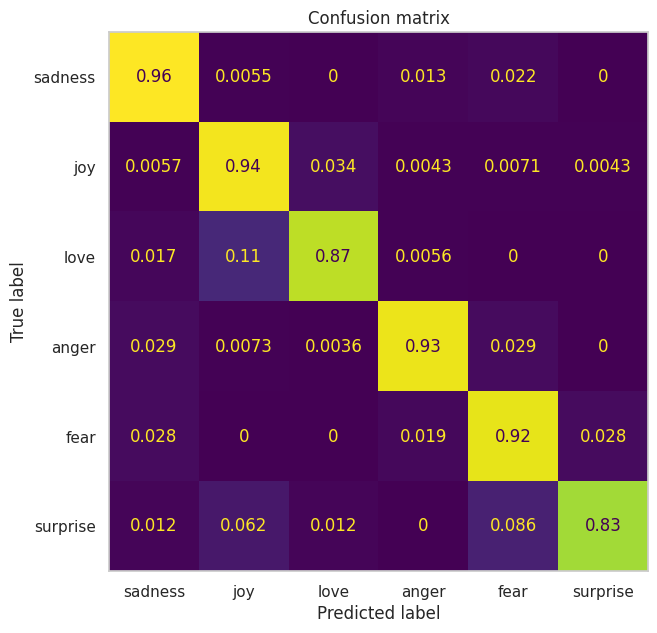

In [61]:
plot_confusion_matrix(y_preds,y_valid,labels)

**Loss Value Mapping**

In [62]:
def forward_pass_with_label(batch):

    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
         # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label,
                                                                    batched=True,
                                                                    batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [63]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

Now we can sort emotions encoded by the losses in descending order
Let's look at the data samples with the highest losses.

In [65]:
pn.extension('tabulator')
show_panel(df_test.sort_values("loss", ascending=False))

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

**USING OUR MODEL**

The model is trained utilising the AutoModelForSequenceClassification which added a classification head to the base DistilBERT model.
We can utilise the pipeline method when we need to make model predictions on new unseen data.

***EXAMPLE :***

Let's say we have new unseen data:





**'I watched a movie last night, it was quite brilliant'**

In [81]:
# Save the model
trainer.save_model()

In [82]:
# load from previously saved model
classifier = pipeline("text-classification", model="distilbert-base-uncased-finetuned-emotion")

# New unseen by model data
new_data = 'I watched a movie last night, it was quite brilliant'

In [87]:
preds = classifier(new_data, return_all_scores=True)


In [88]:
 #Mapping of LABEL_x to their actual emotion names
label_names = {
    'LABEL_0': 'sadness',
    'LABEL_1': 'joy',
    'LABEL_2': 'love',
    'LABEL_3': 'anger',
    'LABEL_4': 'fear',
    'LABEL_5': 'surprise'
}

# Replace the labels with emotion names
for pred in preds:
    for item in pred:
        item['label'] = label_names[item['label']]


print(preds)

[[{'label': 'sadness', 'score': 0.0027515257243067026}, {'label': 'joy', 'score': 0.9859872460365295}, {'label': 'love', 'score': 0.00319196586497128}, {'label': 'anger', 'score': 0.0024171241093426943}, {'label': 'fear', 'score': 0.0013264345470815897}, {'label': 'surprise', 'score': 0.00432564364746213}]]


In [90]:
# Extract the labels and scores from preds
extracted_preds = preds[0]  # Since preds is a list of lists, we take the first (and only) list

# Extract labels and scores
labels = [item['label'] for item in extracted_preds]
scores = [item['score'] for item in extracted_preds]

# Create a DataFrame for plotting
df_preds = pd.DataFrame({'label': labels, 'score': scores})

# Plot using Plotly Express with emotion names on x-axis
fig = px.bar(
    x=df_preds['label'],
    y=100 * df_preds['score'],  # Convert scores to percentages
    labels={'x': 'Emotion', 'y': 'Score (%)'},
    title='Emotion Classification Scores',
    template='plotly_white'
)

# Show the plot
fig.show()
